# Choose which data file you wish to clean

In [47]:
data_file_list = ["ws23", "mh23"]
data_file = data_file_list[0]

# Read in white sands csv files and turn them into dataframes

In [48]:
import os
import pandas as pd

def get_data(data_src_folder_path):
    df_list = []
    for filename in os.listdir(data_src_folder_path):
        df = pd.read_csv(f"{data_src_folder_path}/{filename}")
        df = df[['toeforce_y', 'toe_position_y']] # takes just the two important columns
        df.columns = ["resistance", "depth"] # rename columns
        df_list.append(df)
    return df_list

df_list = get_data(f"/home/frankwoods/Desktop/lassie/data/{data_file}_raw_data")
print(f"example: {df_list[0]}")


example:        resistance     depth
0       -0.683593 -0.188659
1       -0.683593 -0.188659
2       -0.683593 -0.188659
3       -0.683593 -0.188659
4       -0.683593 -0.188659
...           ...       ...
11599   -1.929471 -0.158198
11600   -1.929471 -0.158198
11601   -1.929471 -0.158198
11602   -1.929471 -0.158198
11603   -1.929471 -0.158198

[11604 rows x 2 columns]


# Do you want to generate graphs and save data automatically by running this program?

In [49]:
saving_data = False

# Initial Data Visualization and Summary

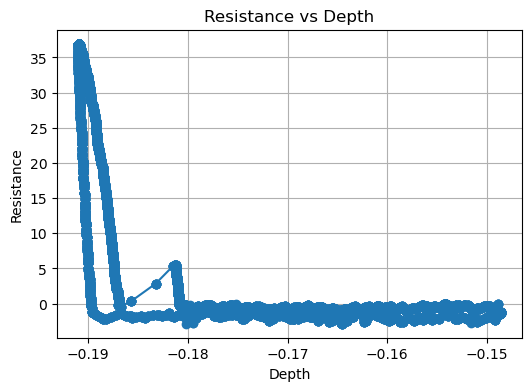

In [50]:


import seaborn as sns
import matplotlib.pyplot as plt

# ---- plot an example graph ----
# Assume you have a DataFrame df with columns 'depth' and 'resistance'
def visualize_data(df_list, graph=False, save_graph_to_folder=False, save_graph_to_folder_location="", box_plots=False, histograms=False, graph_i=15):
    if graph:
        plt.figure(figsize=(6,4))         # Optional: set figure size
        plt.plot(df_list[graph_i]['depth'], df_list[graph_i]['resistance'], marker='o', linestyle='-')
        plt.xlabel('Depth')
        plt.ylabel('Resistance')
        plt.title('Resistance vs Depth')
        plt.grid(True)                    
        plt.show()
    
    if save_graph_to_folder and len(save_graph_to_folder_location) > 0:
        # rm_files_in_folder(save_graph_to_folder_location)
        for i, df in enumerate(df_list):
            plt.figure(figsize=(8,6))         # Optional: set figure size
            plt.plot(df['depth'], df['resistance'], marker='o', linestyle='-')
            plt.xlabel('Depth (m)')
            plt.ylabel('Resistance (N)')
            plt.title('Resistance vs Depth')
            plt.grid(True)
            plt.savefig(f"{save_graph_to_folder_location}{i}")
            plt.close()

    df_combined_row_wise = pd.concat(df_list, axis=0)
    if box_plots:
        plt.figure(figsize=(3,2))         # Optional: set figure size
        # ---- resistance ----
        sns.boxplot(x=df_combined_row_wise['resistance'])
        plt.show()
        resistance_series = df_combined_row_wise['resistance']
        # ---- depth ----
        plt.figure(figsize=(3,2))         # Optional: set figure size
        sns.boxplot(x=df_combined_row_wise['depth'])
        plt.show()
    if histograms:
        plt.hist(df_combined_row_wise["resistance"], bins=30, density=True)
        plt.title("Resistance Histogram")
        plt.show()

        plt.hist(df_combined_row_wise["depth"], bins=30, density=True)
        plt.title("Depth Histogram")
        plt.show()


visualize_data(df_list, graph=True, save_graph_to_folder=saving_data, save_graph_to_folder_location=f"data/{data_file}_raw_data_visual/resistance_depth_")

# Flip curve over y-axis

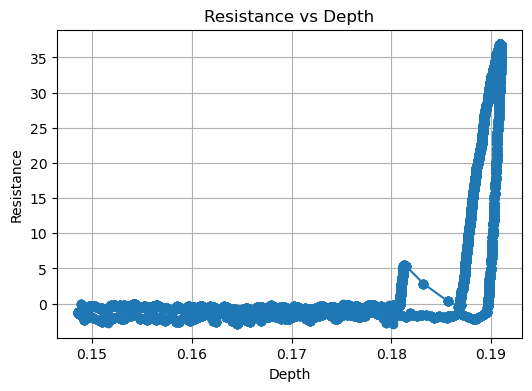

In [51]:
def flip_over_y_axis(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df['depth'] = -copy_df['depth']
        if data_file == "mh23":
            copy_df['resistance'] = -copy_df['resistance']
        cleaned_df_list.append(copy_df)
    return cleaned_df_list

df_list = flip_over_y_axis(df_list)
visualize_data(df_list, graph=True)

# Remove all data points after the max depth

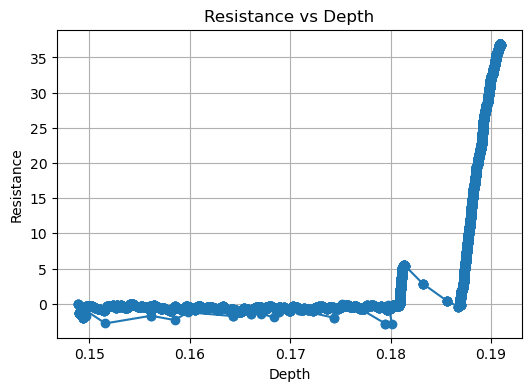

In [52]:
def remove_points_after_max_depth(df_list):
    cleaned_list = []
    for i, df in enumerate(df_list):
        end_idx = df[df["depth"] == df["depth"].max()].index[0]
        cleaned_df = df.iloc[:end_idx+1]
        cleaned_list.append(cleaned_df)
    return cleaned_list

df_list = remove_points_after_max_depth(df_list)
visualize_data(df_list, graph=True)

# Remove all data points before min depth

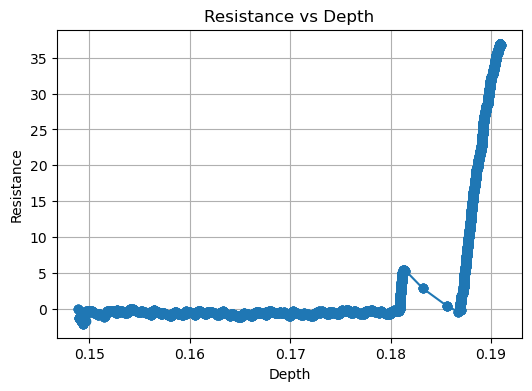

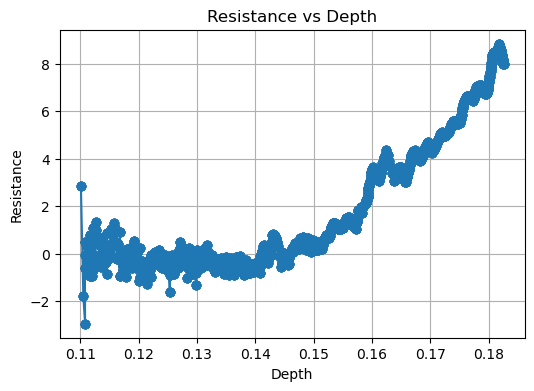

In [53]:
def remove_points_before_min_depth(df_list):
    cleaned_list = []
    for i, df in enumerate(df_list):
        min_idx = df[df["depth"] == df["depth"].min()].index[0]
        cleaned_df = df.iloc[min_idx:]
        cleaned_list.append(cleaned_df)
    return cleaned_list

df_list = remove_points_before_min_depth(df_list)
visualize_data(df_list, graph=True)
visualize_data(df_list, graph=True, graph_i=14)

# Make resistance = 0 for all resistance values < 0

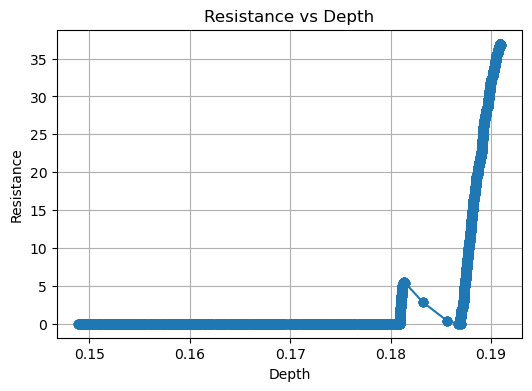

In [54]:
def make_resistance_min_equal_zero(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df["resistance"] = copy_df["resistance"].clip(lower=0)
        cleaned_df_list.append(copy_df)
    return cleaned_df_list
df_list = make_resistance_min_equal_zero(df_list)
visualize_data(df_list, graph=True)

# Make sure depth values are only increasing

Number of non-ascending dataframes: 80


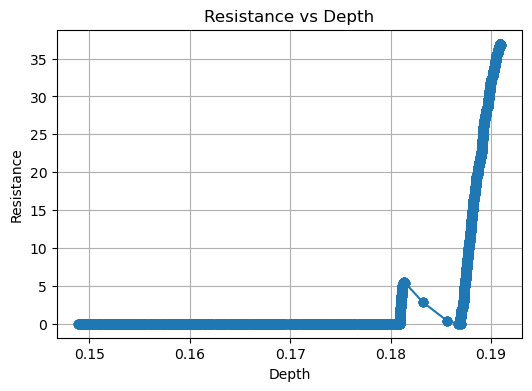

Number of non-ascending dataframes: 0


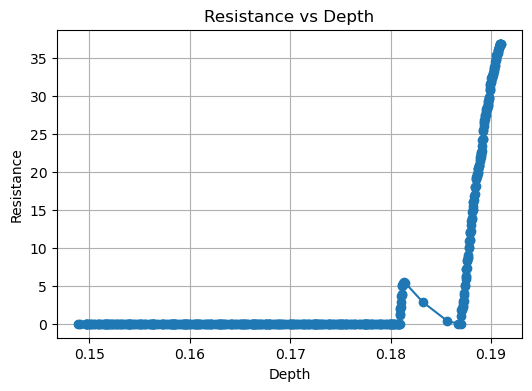

In [55]:
def num_dataframes_with_ascending_depth(df_list):
    count = 0
    for df in df_list:
        if not (df['depth'].is_monotonic_increasing and df['depth'].is_unique): 
            count += 1
    return count

def only_increasing_depth(df_list):
    cleaned_df_list = []
    for df in df_list:
        mask = [1]  # keep the first row
        current_max_depth = df['depth'].iloc[0]
        for i in range(1, len(df)):
            if df['depth'].iloc[i] > current_max_depth:
                current_max_depth = df['depth'].iloc[i]
                mask.append(1)
            else:
                mask.append(0)
        mask_series = pd.Series(mask, index=df.index)
        cleaned_df_list.append(df.loc[mask_series.astype(bool)])

    return cleaned_df_list

# show before and after
print(f"Number of non-ascending dataframes: {num_dataframes_with_ascending_depth(df_list)}")
visualize_data(df_list, graph=True)
df_list = only_increasing_depth(df_list)
print(f"Number of non-ascending dataframes: {num_dataframes_with_ascending_depth(df_list)}")
visualize_data(df_list, graph=True)

# Start each depth-resistance curve when arm first contacts the ground
- Reason why this code is complicated and why we can't just use largest non-zero resistance subrange to capture when ground penetration starts
    - sometimes the curve will rise, hit a crust point, break through the crust, and resistance drops all the way down to 0
    - if we simply started the curve at longest non-zero resistance subrange, we would miss the entire crust break just mentioned and just grab the post-crust break curve

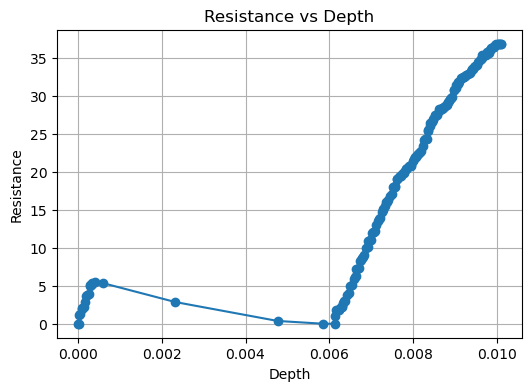

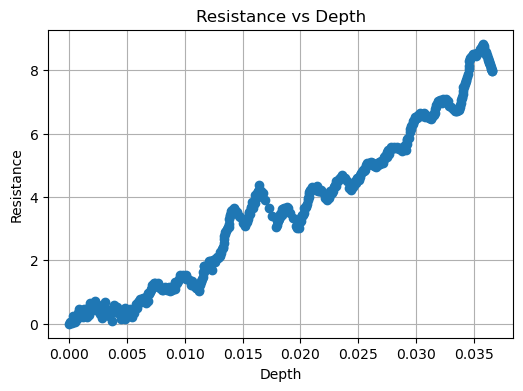

In [56]:
import pandas as pd

def find_positive_subranges_of_resistance(df):
    ranges_above_zero_list = []
    range_max_height_list = []

    in_range = False
    range_start_idx = None
    range_max_resistance = 0

    for i, res in enumerate(df["resistance"]):
        if res > 0:
            if not in_range:
                # starting a new range
                in_range = True
                if i > 0: range_start_idx = i - 1
                else: range_start_idx = 0
                range_max_resistance = res
            else:
                range_max_resistance = max(range_max_resistance, res)
        elif in_range:
            # end of a positive range
            ranges_above_zero_list.append((range_start_idx, i - 1))
            range_max_height_list.append(range_max_resistance)
            in_range = False

    # handle if last element was part of a range
    if in_range:
        ranges_above_zero_list.append((range_start_idx, len(df["resistance"]) - 1))
        range_max_height_list.append(range_max_resistance)

    return ranges_above_zero_list, range_max_height_list

def get_ground_start_idx(df, range_max_res, max_spacing_between_ranges):
    pos_ranges_list, pos_ranges_max_res_list = find_positive_subranges_of_resistance(df)
    if len(pos_ranges_list) < 1: return 0
    # grab the range with the highest resistance (main curve)
    max_resistance_overall = max(pos_ranges_max_res_list)

    # grab all other positive ranges within range_max_resold
    ranges_within_res_list = []
    for i, pos_range in enumerate(pos_ranges_list):
        if pos_ranges_max_res_list[i] > max_resistance_overall * range_max_res:
             ranges_within_res_list.append(pos_range)
    
    # some files have high resistance noise way before penetration even starts
    # need to make sure this high resistance noise is not chosen for where the ground starts
    start_idx = ranges_within_res_list[-1][0] # init start_idx with start of largest curve (last subrange is range_list)
    # case: only one subrange within range_max_resold, the main curve
    if len(ranges_within_res_list) < 2: return start_idx
    # case: many ranges within res threshold
    for i in range(len(ranges_within_res_list)-2, -1, -1): 
        range_start_i = df["depth"].iloc[ranges_within_res_list[i][1]]
        range_end_j = df["depth"].iloc[ranges_within_res_list[i+1][0]]
        if range_end_j - range_start_i > max_spacing_between_ranges * len(df["depth"]):
            start_idx = ranges_within_res_list[i+1][0]
            break
        else:
            start_idx = ranges_within_res_list[i][0]
    return start_idx

def start_curve_at_ground(df, subrange_max_resistance, max_spacing_between_subranges):
    start_idx = get_ground_start_idx(df, subrange_max_resistance, max_spacing_between_subranges)
    df = df.iloc[start_idx:]
    return df

def remove_data_prior_to_ground(df_list, subrange_max_resistance, max_spacing_between_subranges):
    cleaned_df_list = []
    for i, df in enumerate(df_list):
        # if i != 14: continue
        copy_df = df.copy()
        copy_df = start_curve_at_ground(copy_df, subrange_max_resistance, max_spacing_between_subranges)
        copy_df["depth"] = copy_df["depth"] - copy_df['depth'].iloc[0]
        cleaned_df_list.append(copy_df)
    return cleaned_df_list

df_list = remove_data_prior_to_ground(df_list, subrange_max_resistance=0.1, max_spacing_between_subranges=0.00001)
visualize_data(df_list, graph=True)
visualize_data(df_list, graph=True, graph_i=14)



# Interpolation to smooth trend and uniformly resample points

Before interpolation


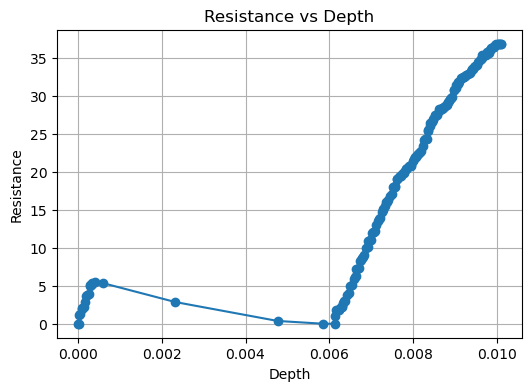

After interpolation


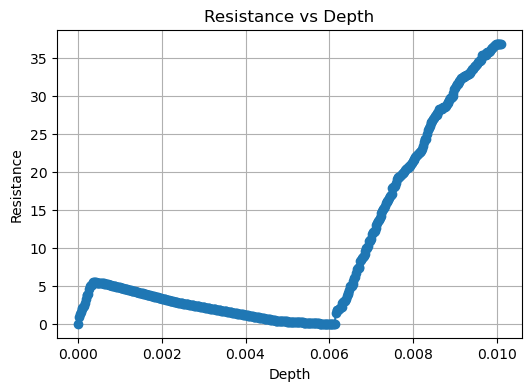

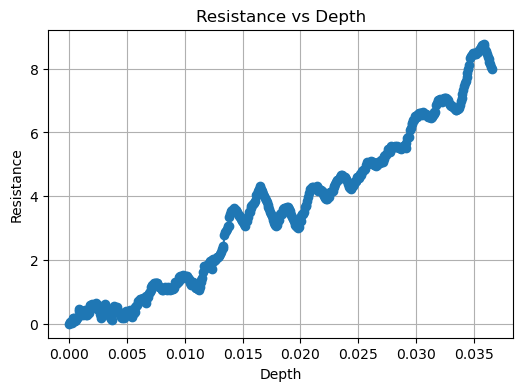

In [57]:
import numpy as np
def interpolate(df_list, num_points):
    interp_df_list = []
    for df in df_list:
        x_intervals = np.linspace(0, df['depth'].max(), num_points, endpoint=True) # 100 points between 0 and trunc_level
        y_new = np.interp(x_intervals, df["depth"], df["resistance"])
        new_df = pd.DataFrame({'depth': x_intervals, 'resistance': y_new})
        interp_df_list.append(new_df)
    return interp_df_list

print("Before interpolation")
visualize_data(df_list, graph=True,)
df_list = interpolate(df_list, 500)
print("After interpolation")
visualize_data(df_list, graph=True)
visualize_data(df_list, graph=True, graph_i=14)


# Remove bad samples

In [58]:
def remove_bad_samples(df_list, remove_list):
    cleaned_samples_list = []
    for i, df in enumerate(df_list):
        if i not in remove_list:
            cleaned_samples_list.append(df)
    return cleaned_samples_list

remove_list = {
    # "ws23": [66, 74], # 63 bad sample, 74 is only data point that won't clean properly
    "ws23": [66], # 63 bad sample, 74 is only data point that won't clean properly
    "mh23": [0, 14, 19, 23, 26, 35, 36, 37, 38, 39, 45, 46, 47, 49, 50, 53, 58, 65, 74, 79]
}

df_list = remove_bad_samples(df_list, remove_list[data_file])
print(f"df_list length: {len(df_list)}")
print("bad samples removed")

df_list length: 80
bad samples removed


# Save photos of all cleaned curves

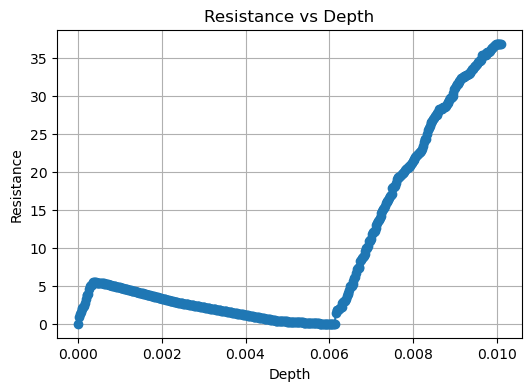

In [59]:
visualize_data(df_list, graph=True, save_graph_to_folder=saving_data, save_graph_to_folder_location="/home/frankwoods/Desktop/lassie/data/ws23_processed_data_visual/resistance_depth_")

# Save the cleaned csv files

In [60]:
def save_data_csv(final_df_list, save_to_folder_path, save: bool):
    if save:
        for i in range(len(final_df_list)):
            final_df_list[i].to_csv(f"{save_to_folder_path}{data_file}_processed_data/resistance_depth_{i}.csv")

save_data_csv(df_list, save_to_folder_path="/home/frankwoods/Desktop/lassie/data/", save=saving_data)